# Multi-dimensional 1559 Simulation

(adapted from 2021 / congestion 2.0)

2022S: we simulate the effects of multidimensional 1559 under 2 basefees.

We first import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cProfile
import random

from importlib import reload

import simulator

In [13]:
reload(simulator)

<module 'simulator' from '/home/yan/Projects/camcos/simulations/2022/simulator.py'>

We create a BasefeeSimulator() object, which has a simulate() method that runs a simulator for a certain number of turns. We run the simulation and save the summary data.

In [14]:
bf_standard = simulator.Basefee(1.0/8, 15000000, 30000000) # d, target gas, max gas
bf_sim = simulator.BasefeeSimulator(bf_standard)
s = bf_sim.simulate(200)
basefees_data, blocks_data, mempools_data, mempools_bf_data, txn_counts_data, wait_times_data = s

# cProfile.run("simulate(100)")

# Basefee Over Time:

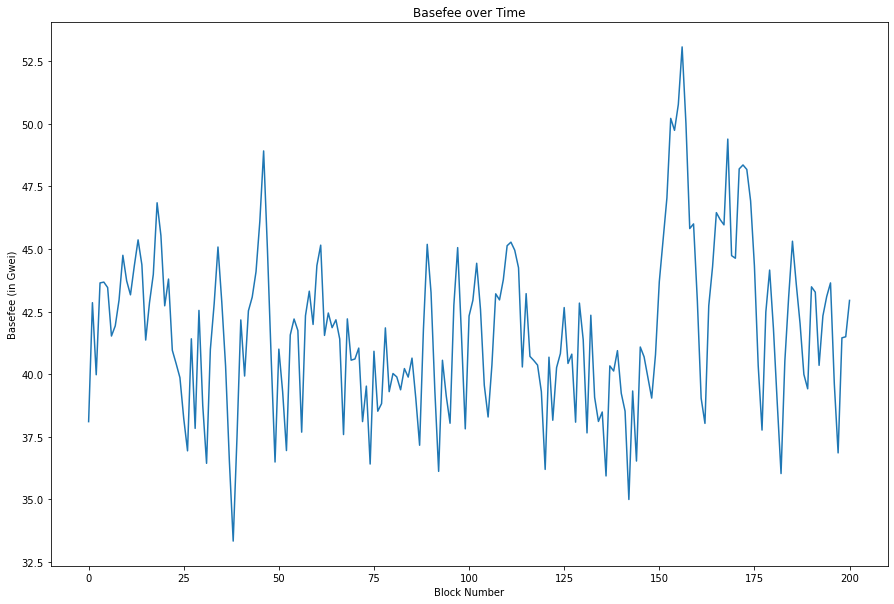

In [15]:
plt.rcParams["figure.figsize"] = (15,10)
plt.title("Basefee over Time")
plt.xlabel("Block Number")
plt.ylabel("Basefee (in Gwei)")
plt.plot(basefees_data)

# Mempool Analysis
We examine some statistics on the mempools throughout the simulation to quantify congestion.

### Mempool Size Over Time
We show mempool sizes in both total gas and in total number of transactions

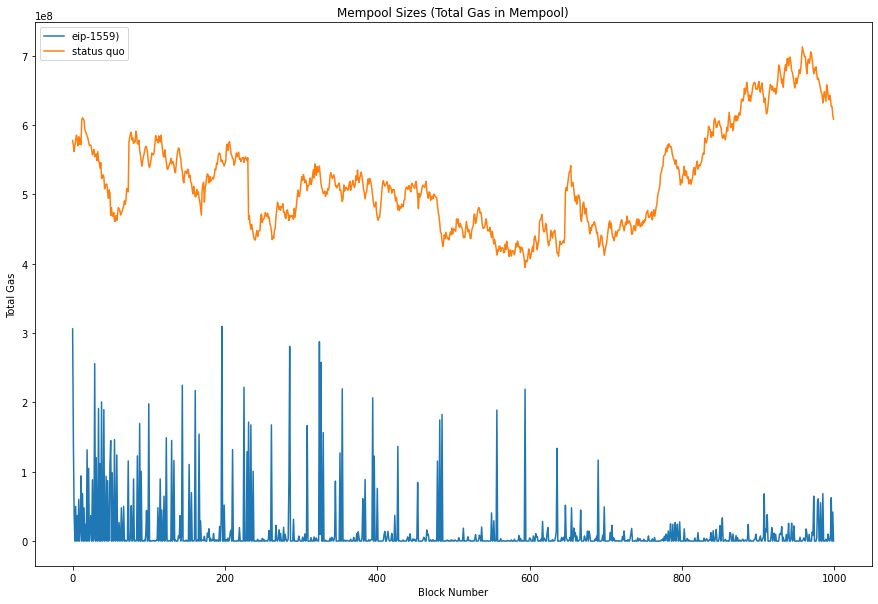

In [9]:
sq_mempool_sizes_gl = [sum(x["gas limit"]) for x in sq_mempools_data]
eip_mempool_sizes_bf_gl = [sum(x["gas limit"]) for x in eip_mempools_bf_data]

plt.title("Mempool Sizes (Total Gas in Mempool)")
plt.xlabel("Block Number")
plt.ylabel("Total Gas")
plt.plot(eip_mempool_sizes_bf_gl, label="eip-1559)")
plt.plot(sq_mempool_sizes_gl, label="status quo")
plt.legend(loc="upper left")

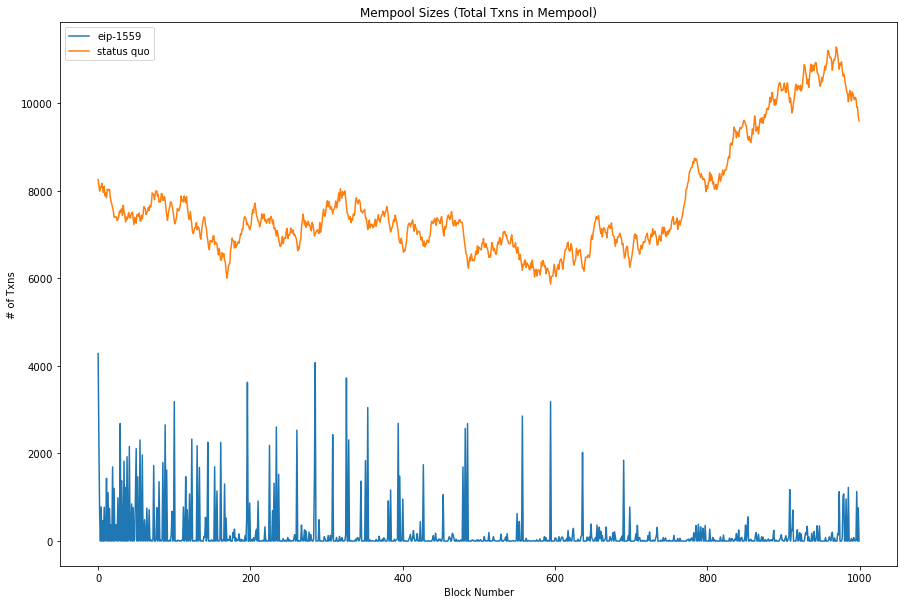

In [10]:
sq_mempool_sizes = [len(x) for x in sq_mempools_data]
eip_mempool_sizes_bf = [len(x) for x in eip_mempools_bf_data]

plt.title("Mempool Sizes (Total Txns in Mempool)")
plt.xlabel("Block Number")
plt.ylabel("# of Txns")
plt.plot(eip_mempool_sizes_bf, label="eip-1559")
plt.plot(sq_mempool_sizes, label="status quo")
plt.legend(loc="upper left")

### Lost Revenue Over Time
Show the total unpaid monetary value in the mempools. 

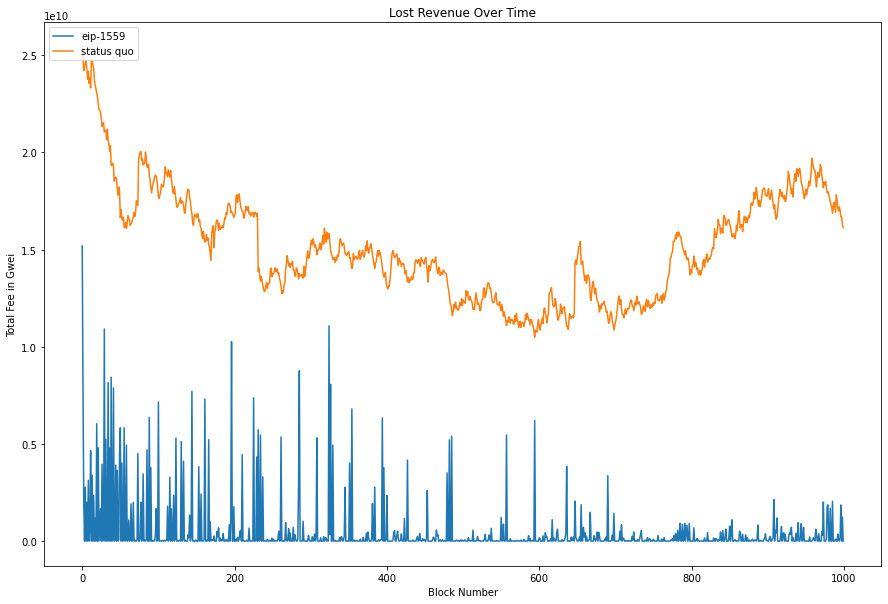

In [11]:
eip_mempool_lrevs = [sum(i["amount paid"]) for i in eip_mempools_bf_data]
sq_mempool_lrevs = [sum(i["amount paid"]) for i in sq_mempools_data]

plt.title("Lost Revenue Over Time")
plt.xlabel("Block Number")
plt.ylabel("Total Fee in Gwei")
plt.plot(eip_mempool_lrevs, label="eip-1559")
plt.plot(sq_mempool_lrevs, label="status quo")
plt.legend(loc="upper left")

### Ratio of Wait Times
After every 100 blocks, we calculate the average wait time of transactions included in blocks, denoted as $\mu$. We then calculate $X/Y$ for $X$ := the number of transactions with wait times $\leq \mu$ and $Y$ := all other transactions. The following is a plot of those ratios. 

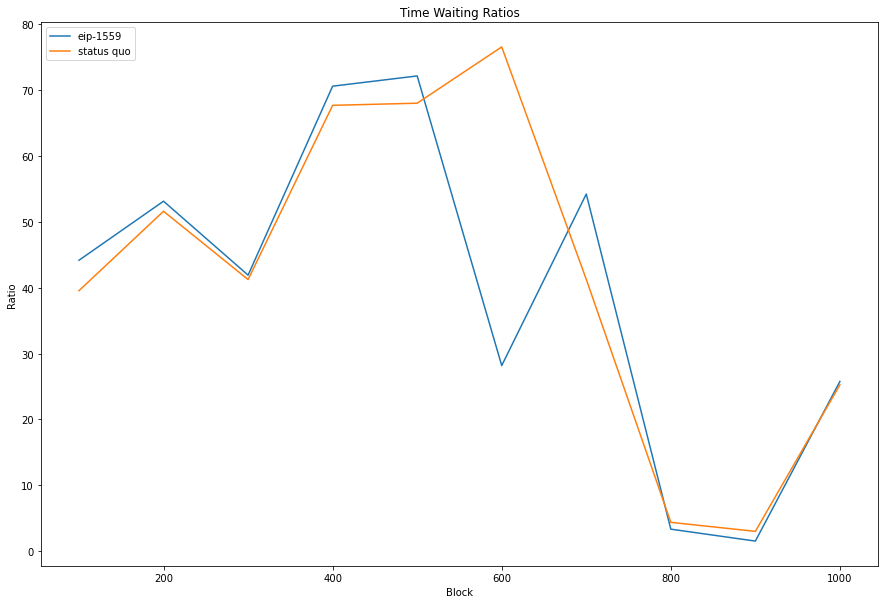

In [12]:
eip_ratios = []
sq_ratios = []

for i in range(len(sq_blocks_data) // 100):
    eip_section = eip_wait_times[i*100:(i+1)*100]
    sq_section = sq_wait_times[i*100:(i+1)*100]
    
    eip_average = sum([sum(x) for x in eip_section]) / 100
    sq_average = sum([sum(x) for x in sq_section]) / 100
    
    X_sq = sum([sum([x for x in y if x <= sq_average ]) for y in sq_section])
    X_eip = sum([sum([x for x in y if x <= eip_average]) for y in eip_section])
    
    sq_waiting = len(sq_mempools_data[100*(i+1) - 1])
    eip_waiting = len(eip_mempools_data[100*(i+1) - 1])
    
    Y_sq = sum([sum([x for x in y if x > sq_average ]) for y in sq_section]) + sq_waiting
    Y_eip = sum([sum([x for x in y if x > eip_average]) for y in eip_section]) + eip_waiting
    
    eip_ratios.append(X_eip / Y_eip)
    sq_ratios.append(X_sq / Y_sq)

plt.title("Time Waiting Ratios")
plt.xlabel("Block")
plt.ylabel("Ratio")
plt.plot([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], eip_ratios, label="eip-1559")
plt.plot([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], sq_ratios, label="status quo")
plt.legend(loc="upper left")

### Average Wait Time of Each Block
Average wait time taken after every 10 blocks

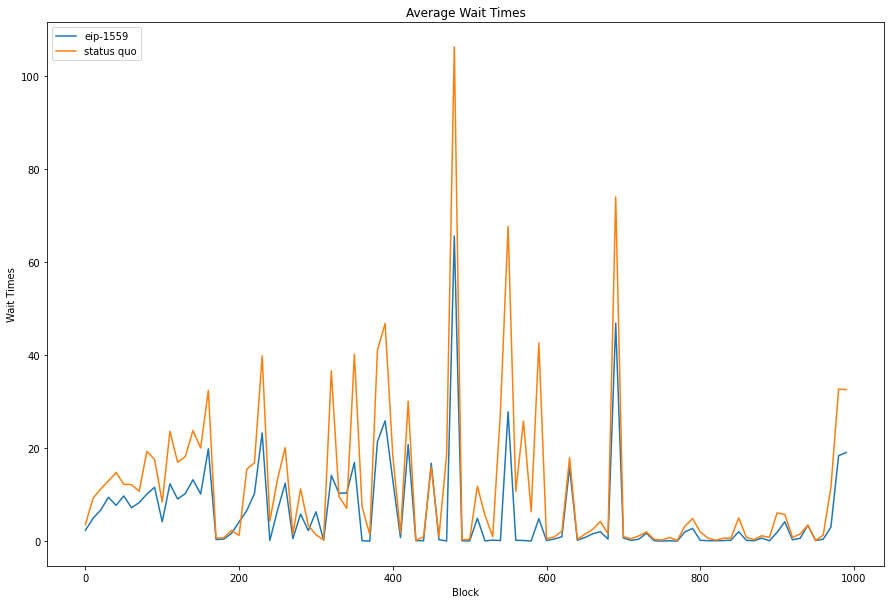

In [13]:
eip_avg_wait = [sum(x)/len(x) for x in eip_wait_times]
sq_avg_wait = [sum(x)/len(x) for x in sq_wait_times]

eip_rolling_avg = [sum(eip_avg_wait[i*10 : (i+1)*10]) / 10 for i in range(len(eip_avg_wait) // 10)]
sq_rolling_avg = [sum(sq_avg_wait[i*10 : (i+1)*10]) / 10 for i in range(len(sq_avg_wait) // 10)]

wait_ratios = [y // x for x, y in zip(eip_rolling_avg, sq_rolling_avg)]

plt.title("Average Wait Times")
plt.xlabel("Block")
plt.ylabel("Wait Times")
plt.plot([i*10 for i in range(100)], eip_rolling_avg, label="eip-1559")
plt.plot([i*10 for i in range(100)], sq_rolling_avg, label="status quo")
# plt.plot([i*10 for i in range(100)], wait_ratios, label="status quo / eip")
plt.legend(loc="upper left")


# Other Metrics

### Total Eth Spent in Both Systems

In [14]:
#compare total amount spent in both simulations
eip_mempool_sums = [sum(x["amount paid"]) for x in eip_mempools_data]
sq_mempool_sums = [sum(x["amount paid"]) for x in sq_mempools_data]
print("total eth spent in eip-1559: ", sum(eip_mempool_sums) / 10**9)
print("total eth spent in status quo: ", sum(sq_mempool_sums) / 10**9)
print("total eth status quo - total eth eip-1559: ", (sum(sq_mempool_sums) / 10**9) - (sum(eip_mempool_sums) / 10**9))

total eth spent in eip-1559:  15136.862396577762
total eth spent in status quo:  15144.382532213396
total eth status quo - total eth eip-1559:  7.520135635633778
